Load MNIST dataset . Flatten the (28*28) image to 784. Do PCA on it and take only the first 30 eigenvalues with
their corresponding eigenvectors .Now , project the data onto these eigenvectors and reconstruct them .

In [1]:
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Conv1D
from keras import backend as k
(x_train, y_train), (x_test, y_test) = mnist.load_data()


img_rows, img_cols=28, 28

if k.image_data_format() == 'channels_first':
  x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
  x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
  inpx = (1, img_rows, img_cols)

else:
  x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
  x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
  inpx = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train[:, 1:]

In [3]:
x_train.data.shape

(60000, 28, 28, 1)

In [4]:
x_train.data.shape[0]

60000

In [5]:
x_train=x_train.reshape((x_train.data.shape[0], x_train.data.shape[1]*x_train.data.shape[2]))

In [6]:
x_test.data.shape

(10000, 28, 28, 1)

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_r = pca.fit(x_train).transform(x_train)

In [9]:
x_train.data.shape

(60000, 784)

In [10]:
pca.explained_variance_ratio_

array([0.09704716, 0.07095958], dtype=float32)

Text(0.5, 0.98, '2-Component PCA')

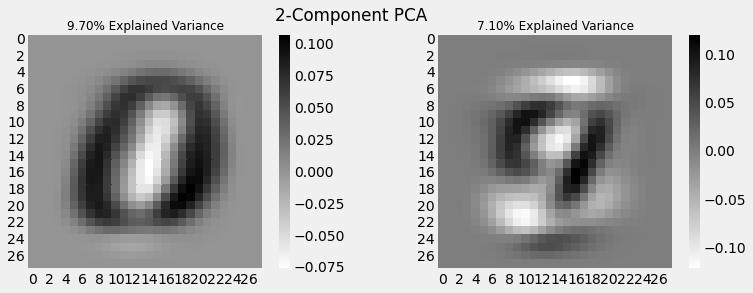

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

fig, axarr = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(pca.components_[0, :].reshape(28, 28), ax=axarr[0], cmap='gray_r')
sns.heatmap(pca.components_[1, :].reshape(28, 28), ax=axarr[1], cmap='gray_r')
axarr[0].set_title(
    "{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[0]*100),
    fontsize=12
)
axarr[1].set_title(
    "{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[1]*100),
    fontsize=12
)
axarr[0].set_aspect('equal')
axarr[1].set_aspect('equal')

plt.suptitle('2-Component PCA')

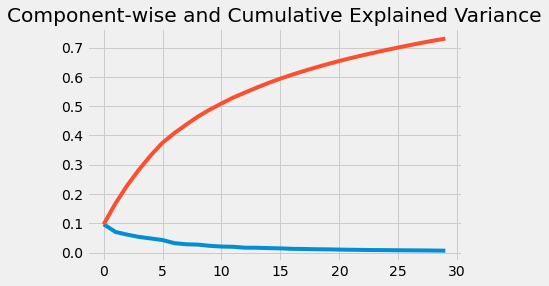

In [25]:
import numpy as np

pca = PCA(n_components=30)
X_r = pca.fit(x_train).transform(x_train)

plt.plot(range(30), pca.explained_variance_ratio_)
plt.plot(range(30), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")
pass

In [13]:
pca = PCA(n_components=30)
X_r = pca.fit(x_train).transform(x_train)

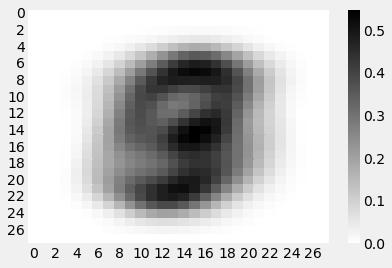

In [14]:
import pandas as pd
sns.heatmap(pd.DataFrame(x_train).mean().values.reshape(28, 28), cmap='gray_r')

In [15]:
def reconstruction(X, n, trans):
    """
    Creates a reconstruction of an input record, X, using the topmost (n) vectors from the
    given transformation (trans)
    
    Note 1: In this dataset each record is the set of pixels in the image (flattened to 
    one row).
    Note 2: X should be normalized before input.
    """
    vectors = [trans.components_[n] * X[n] for n in range(0, n)]
    
    # Invert the PCA transformation.
    ret = trans.inverse_transform(X)
    
    # This process results in non-normal noise on the margins of the data.
    # We clip the results to fit in the [0, 1] interval.
    ret[ret < 0] = 0
    ret[ret > 1] = 1
    return ret

Text(0.5, 1.0, 'reconstruction')

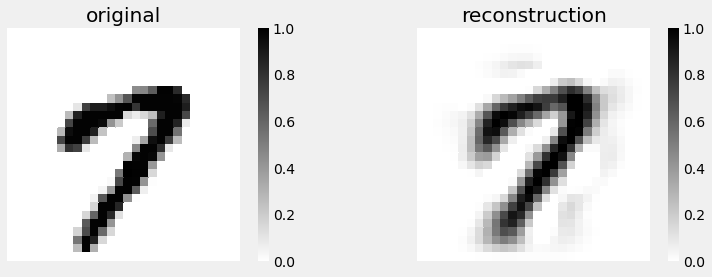

In [16]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(x_train[15, :].reshape(28, 28), cmap='gray_r',
            ax=axarr[0])
sns.heatmap(reconstruction(X_r[15, :], 30, pca).reshape(28, 28), cmap='gray_r',
            ax=axarr[1])
axarr[0].set_aspect('equal')
axarr[0].axis('off')
axarr[0].set_title('original')
axarr[1].set_aspect('equal')
axarr[1].axis('off')
axarr[1].set_title('reconstruction')

In [17]:
def n_sample_reconstructions(X, n_samples=5, trans_n=30, trans=None):
    """
    Returns a tuple with `n_samples` reconstructions of records from the feature matrix X,
    as well as the indices sampled from X.
    """
    sample_indices = np.round(np.random.random(n_samples)*len(X))
    return (sample_indices, 
            np.vstack([reconstruction(X[int(ind)], trans_n, trans) for ind in sample_indices]))


def plot_reconstructions(X, n_samples=5, trans_n=30, trans=None):
    """
    Plots `n_samples` reconstructions.
    """
    fig, axarr = plt.subplots(n_samples, 3, figsize=(12, n_samples*4))
    ind, reconstructions = n_sample_reconstructions(X, n_samples, trans_n, trans)
    for (i, (ind, reconstruction)) in enumerate(zip(ind, reconstructions)):
        ax0, ax1, ax2 = axarr[i][0], axarr[i][1], axarr[i][2]
        sns.heatmap(x_train[int(ind), :].reshape(28, 28), cmap='gray_r', ax=ax0)
        sns.heatmap(reconstruction.reshape(28, 28), cmap='gray_r', ax=ax1)
        sns.heatmap(np.abs(x_train[int(ind), :] - reconstruction).reshape(28, 28), 
                    cmap='gray_r', ax=ax2)
        ax0.axis('off')
        ax0.set_aspect('equal')
        ax0.set_title("Original Image", fontsize=12)
        ax1.axis('off')
        ax1.set_aspect('equal')
        ax1.set_title("30-Vector Reconstruction", fontsize=12)
        ax2.axis('off')
        ax2.set_title("Original-Reconstruction Difference", fontsize=12)
        ax2.set_aspect('equal')

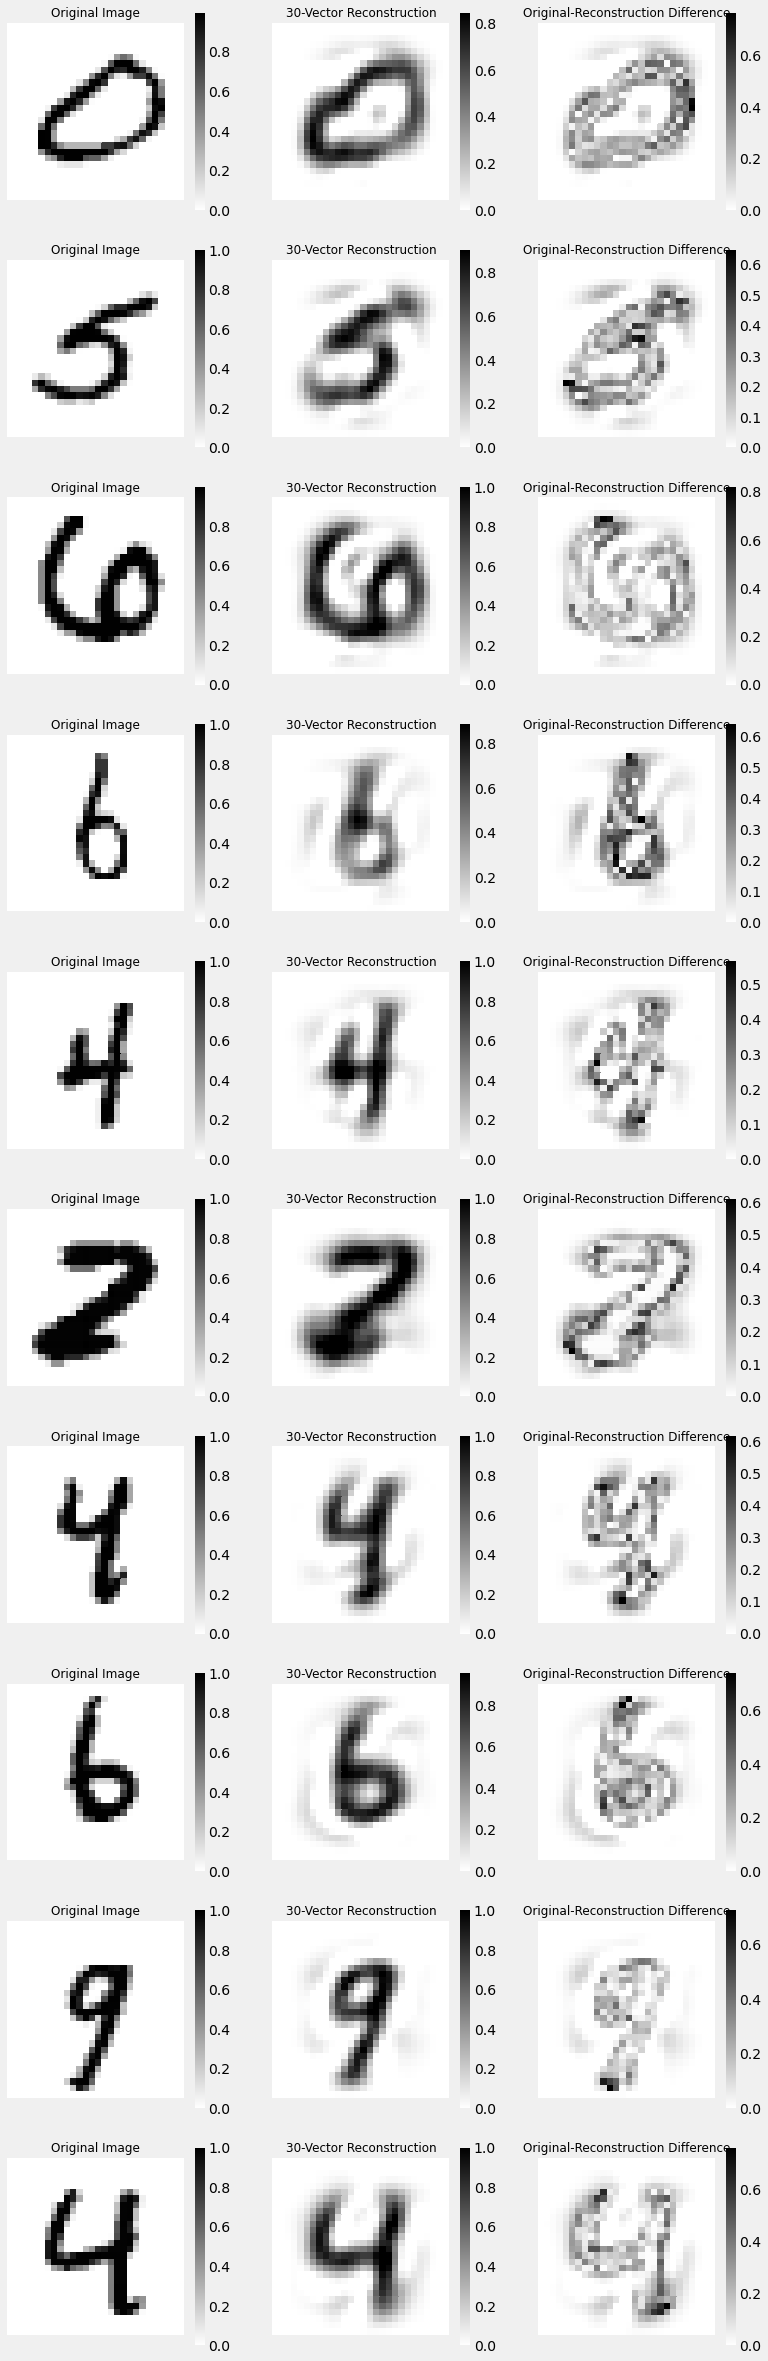

In [18]:
plot_reconstructions(X_r, n_samples=10, trans_n=30, trans=pca)

In [20]:
from sklearn.metrics import mean_squared_error

def quartile_record(X, vector, q=0.5):
    """
    Returns the data which is the q-quartile fit for the given vector.
    """
    errors = [mean_squared_error(x_train[i, :], vector) for i in range(len(x_train))]
    errors = pd.Series(errors)
    
    e_value = errors.quantile(q, interpolation='lower')
    return X[errors[errors == e_value].index[0], :]

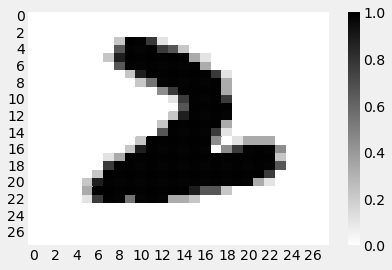

In [21]:
sns.heatmap(quartile_record(x_train, pca.components_[0], q=0.98).reshape(28, 28), 
            cmap='gray_r')

In [22]:
def plot_quartiles(X, trans, n):

    fig, axarr = plt.subplots(n, 7, figsize=(12, n*2))
    for i in range(n):
        vector = trans.components_[i, :]
        sns.heatmap(quartile_record(X, vector, q=0.02).reshape(28, 28), 
            cmap='gray_r', ax=axarr[i][0], cbar=False)
        axarr[i][0].set_aspect('equal')
        axarr[i][0].axis('off')
        
        sns.heatmap(quartile_record(X, vector, q=0.1).reshape(28, 28), 
            cmap='gray_r', ax=axarr[i][1], cbar=False)
        axarr[i][1].set_aspect('equal')
        axarr[i][1].axis('off')
        
        sns.heatmap(quartile_record(X, vector, q=0.25).reshape(28, 28), 
            cmap='gray_r', ax=axarr[i][2], cbar=False)
        axarr[i][2].set_aspect('equal')
        axarr[i][2].axis('off')
        
        sns.heatmap(quartile_record(X, vector, q=0.5).reshape(28, 28), 
            cmap='gray_r', ax=axarr[i][3], cbar=False)
        axarr[i][3].set_aspect('equal')
        axarr[i][3].axis('off')

        sns.heatmap(quartile_record(X, vector, q=0.75).reshape(28, 28), 
            cmap='gray_r', ax=axarr[i][4], cbar=False)
        axarr[i][4].set_aspect('equal')
        axarr[i][4].axis('off')

        sns.heatmap(quartile_record(X, vector, q=0.9).reshape(28, 28), 
            cmap='gray_r', ax=axarr[i][5], cbar=False)
        axarr[i][5].set_aspect('equal')
        axarr[i][5].axis('off')        
        
        sns.heatmap(quartile_record(X, vector, q=0.98).reshape(28, 28), 
            cmap='gray_r', ax=axarr[i][6], cbar=False)        
        axarr[i][6].set_aspect('equal')
        axarr[i][6].axis('off')
        
    axarr[0][0].set_title('2nd Percentile', fontsize=12)
    axarr[0][1].set_title('10th Percentile', fontsize=12)
    axarr[0][2].set_title('25th Percentile', fontsize=12)
    axarr[0][3].set_title('50th Percentile', fontsize=12)
    axarr[0][4].set_title('75th Percentile', fontsize=12)
    axarr[0][5].set_title('90th Percentile', fontsize=12)
    axarr[0][6].set_title('98th Percentile', fontsize=12)

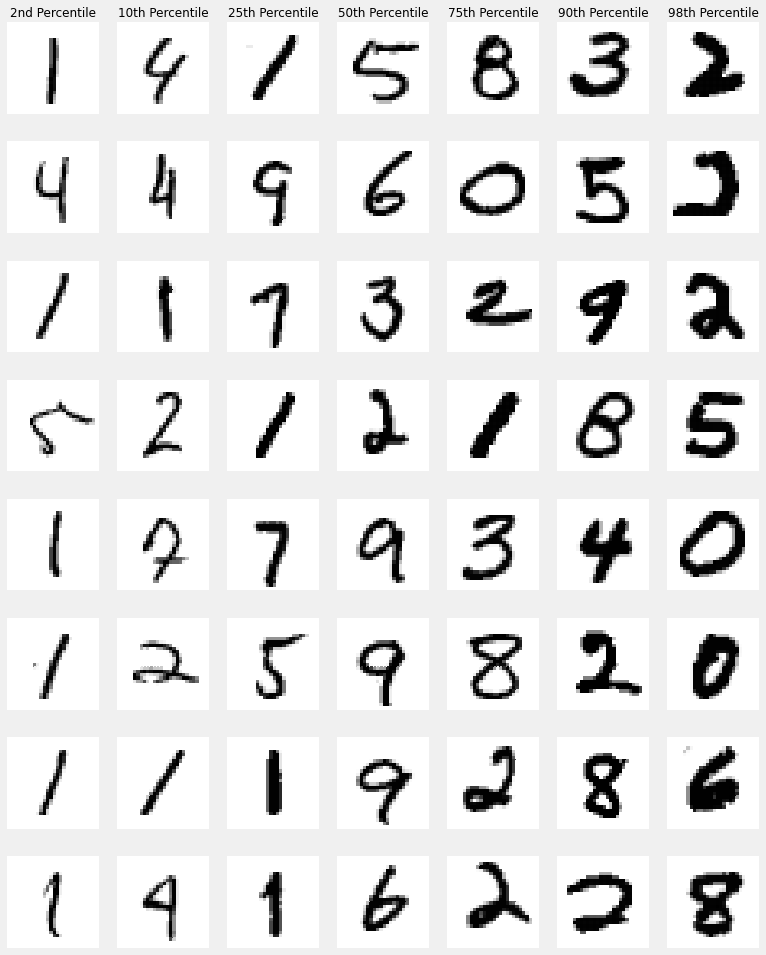

In [23]:
plot_quartiles(x_train, pca, 8)

In [27]:
def record_similarity(X, vector, metric=mean_squared_error):
    """
    Returns the record similarity to the vector, using MSE is the measurement metric.
    """
    return pd.Series([mean_squared_error(x_train[i, :], vector) for i in range(len(x_train))])

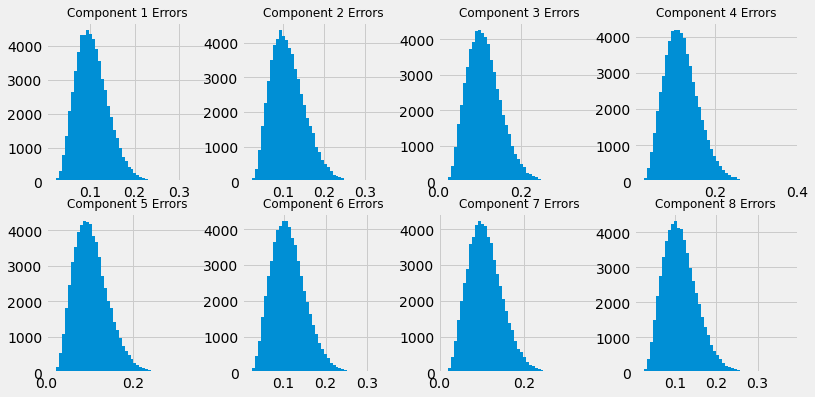

In [30]:
fig, axarr = plt.subplots(2, 4, figsize=(12, 6))
axarr = np.array(axarr).flatten()

for i in range(0, 8):
    record_similarity(x_train, pca.components_[i]).plot.hist(bins=50, ax=axarr[i])
    axarr[i].set_title("Component {0} Errors".format(i + 1), fontsize=12)
    axarr[i].set_xlabel("")
    axarr[i].set_ylabel("")

• Encoder
– input (784)
– fc (512)
– fc (256)
– fc (128)
– fc (30)

• Decoder
– fc (128)
– fc (256)
– fc (784)

Use ReLU as the activation function. Show the training and validation accuracy plot. Compare the Reconstruction Accuracy.
Also Compare visually by plotting outputs for each of the class for both PCA and autoencoder

In [1]:
#import all the dependencies
from keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from keras import Input, Model
#from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

In [35]:
import tensorflow as tf  
from tensorflow import keras
import cv2
import numpy as np


(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()  # loads the popular "mnist" training dataset

x_train = x_train/255.0  # scales the data. pixel values range from 0 to 255, so this makes it range 0 to 1
x_test = x_test/255.0  # scales the data. pixel values range from 0 to 255, so this makes it range 0 to 1


encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = keras.layers.Flatten()(encoder_input)
#encoder_output = keras.layers.Dense(64, activation="relu")(x)
encoded1 = Dense(512, activation='relu')(x)
encoded2 = Dense(256, activation='relu')(encoded1)
encoded3 = Dense(128, activation='relu')(encoded2)
encoder_output = Dense(30, activation='relu')(encoded3)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

#decoder_input = keras.layers.Dense(64, activation="relu")(encoder_output)
decoder_input = Dense(128, activation='relu')(encoder_output)
decoded2 = Dense(256, activation='relu')(decoder_input)
#decoded3 = Dense(784, activation='relu')(decoded2)
x = keras.layers.Dense(784, activation="relu")(decoded2)
decoder_output = keras.layers.Reshape((28, 28, 1))(x)

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

autoencoder.compile(opt, loss='mse',metrics=['accuracy'])

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               401920    
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 30)                3870      
                                                                 
 dense_11 (Dense)            (None, 128)               

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
history = autoencoder.fit(
      x_train,
      x_train,
      epochs=10, 
      batch_size=32, validation_split=0.10
        ) 

Epoch 1/10
1688/1688 [==============================] - 16s 9ms/step - loss: 0.0243 - accuracy: 0.8112 - val_loss: 0.0182 - val_accuracy: 0.8132
Epoch 2/10
1688/1688 [==============================] - 15s 9ms/step - loss: 0.0167 - accuracy: 0.8135 - val_loss: 0.0154 - val_accuracy: 0.8139
Epoch 3/10
1688/1688 [==============================] - 15s 9ms/step - loss: 0.0151 - accuracy: 0.8138 - val_loss: 0.0148 - val_accuracy: 0.8141
Epoch 4/10
1688/1688 [==============================] - 16s 9ms/step - loss: 0.0146 - accuracy: 0.8140 - val_loss: 0.0147 - val_accuracy: 0.8140
Epoch 5/10
1688/1688 [==============================] - 16s 10ms/step - loss: 0.0141 - accuracy: 0.8140 - val_loss: 0.0139 - val_accuracy: 0.8143
Epoch 6/10
1688/1688 [==============================] - 20s 12ms/step - loss: 0.0138 - accuracy: 0.8141 - val_loss: 0.0137 - val_accuracy: 0.8143
Epoch 7/10
1688/1688 [==============================] - 25s 15ms/step - loss: 0.0134 - accuracy: 0.8142 - val_loss: 0.0132 - val

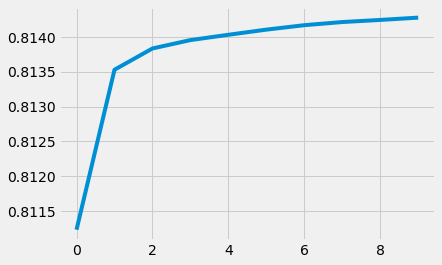

In [37]:
t_acc=history.history['accuracy']
plt.plot(t_acc)

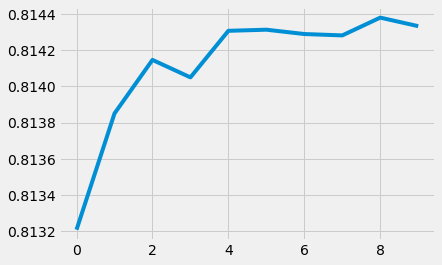

In [38]:
v_acc=history.history['val_accuracy']
plt.plot(v_acc)

In [39]:
v_loss=history.history['val_loss']

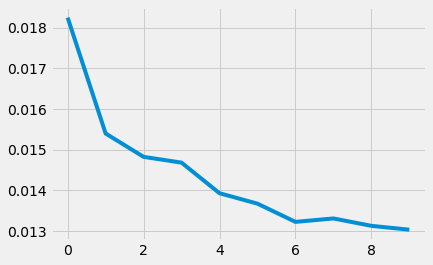

In [40]:
plt.plot(v_loss)

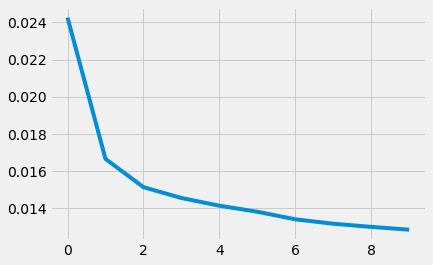

In [41]:
t_loss=history.history['loss']
plt.plot(t_loss)

In [42]:
example = encoder.predict([ x_test[0].reshape(-1, 28, 28, 1) ])

print(example[0].shape)
print(example[0])

1/1 [==============================] - 0s 113ms/step
(30,)
[1.1371948  2.7120464  2.4927208  1.0607805  2.6749806  0.
 1.3311324  3.32302    3.2066998  0.         1.1573516  0.
 0.6823003  1.8037091  1.7973914  0.         1.940695   0.13681383
 2.3129115  1.9421171  2.3112626  0.         1.5329149  2.7553923
 2.014098   2.2050002  0.         0.7020089  2.2539287  2.2572567 ]


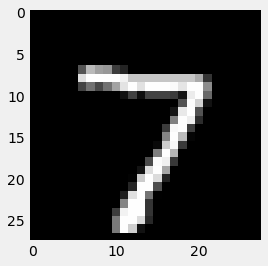

In [45]:
plt.imshow(x_test[0], cmap="gray")
plt.grid()

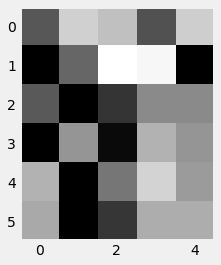

In [44]:
#plt.imshow(example[0], cmap="gray")
plt.imshow(example[0].reshape((6,5)), cmap="gray")
plt.grid()

In [26]:
ae_out = autoencoder.predict([ x_test[0].reshape(-1, 28, 28, 1) ])
img = ae_out[0]  # predict is done on a vector, and returns a vector, even if its just 1 element, so we still need to grab the 0th
#plt.imshow(ae_out[0], cmap="gray")

1/1 [==============================] - 0s 99ms/step


In [27]:
img.shape

(28, 28, 1)

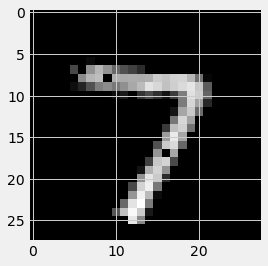

In [28]:
plt.imshow(img.reshape((28,28)),cmap="gray")

313/313 [==============================] - 1s 4ms/step


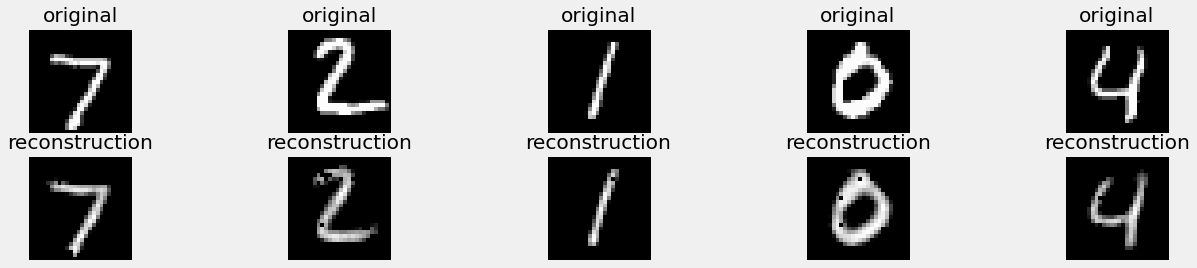

In [53]:
pred = autoencoder.predict(x_test)
plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('original')
    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('reconstruction')
plt.show()

2 Experimenting with hidden units of varying sizes

Train a standard auto-encoder with the following architecture:

• fc(x)-fc(784)

Here, x is the size of the hidden unit. The architecture consists of only a hidden layer and the output layer. Using x =
[64, 128, 256], do the following:

1. Plot the Training and validation accuracy plot for the 3 cases

2. Test the network on any one of your testset images and compare the quality of reconstruction for different values of x.
This comparison should be done visually.

3. What outputs do you get if you pass a non-digit image (Try Fashion MNIST) and random noise images through the
network?

In [56]:
encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = keras.layers.Flatten()(encoder_input)
encoder_output = keras.layers.Dense(64, activation="relu")(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.Dense(64, activation="relu")(encoder_output)
x = keras.layers.Dense(784, activation="relu")(decoder_input)
decoder_output = keras.layers.Reshape((28, 28, 1))(x)

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

autoencoder.compile(opt, loss='mse', metrics=['accuracy'])

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_20 (Dense)            (None, 64)                50240     
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 784)               50960     
                                                                 
 reshape_4 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
Total params: 105,360
Trainable params: 105,360
Non-tra

In [57]:
history = autoencoder.fit(
      x_train,
      x_train,
      epochs=10, 
      batch_size=32, validation_split=0.10
        ) 

Epoch 1/10
1688/1688 [==============================] - 10s 5ms/step - loss: 0.0210 - accuracy: 0.8126 - val_loss: 0.0148 - val_accuracy: 0.8147
Epoch 2/10
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0139 - accuracy: 0.8146 - val_loss: 0.0135 - val_accuracy: 0.8149
Epoch 3/10
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0131 - accuracy: 0.8148 - val_loss: 0.0128 - val_accuracy: 0.8149
Epoch 4/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0126 - accuracy: 0.8148 - val_loss: 0.0125 - val_accuracy: 0.8150
Epoch 5/10
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0124 - accuracy: 0.8148 - val_loss: 0.0124 - val_accuracy: 0.8150
Epoch 6/10
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0123 - accuracy: 0.8148 - val_loss: 0.0124 - val_accuracy: 0.8150
Epoch 7/10
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0122 - accuracy: 0.8149 - val_loss: 0.0122 - val_accuracy

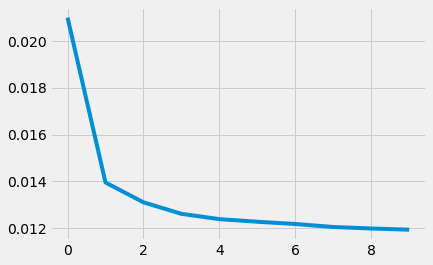

In [63]:
t_loss=history.history['loss']
plt.plot(t_loss)

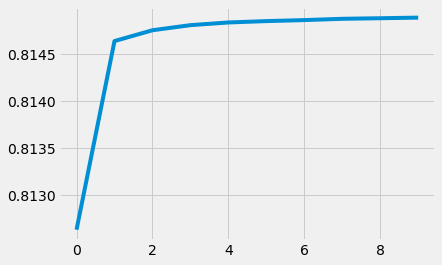

In [64]:
t_acc=history.history['accuracy']
plt.plot(t_acc)

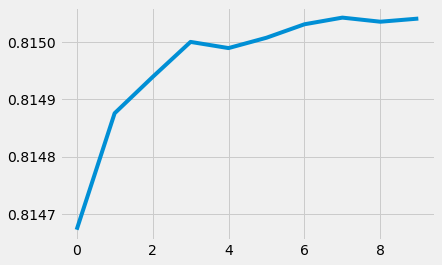

In [65]:
v_acc=history.history['val_accuracy']
plt.plot(v_acc)

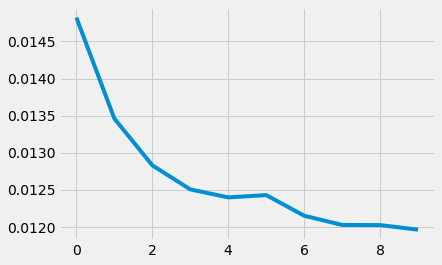

In [66]:
v_loss=history.history['val_loss']
plt.plot(v_loss)

313/313 [==============================] - 1s 2ms/step


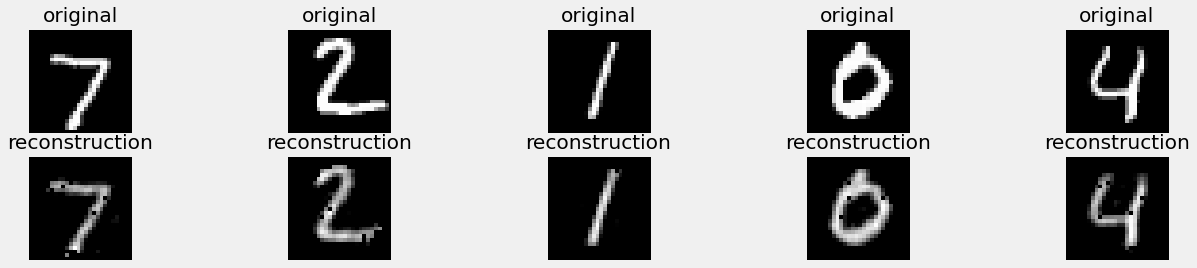

In [67]:
pred = autoencoder.predict(x_test)
plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('original')
    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('reconstruction')
plt.show()

In [58]:
example = encoder.predict([ x_test[0].reshape(-1, 28, 28, 1) ])

print(example[0].shape)
print(example[0])

1/1 [==============================] - 0s 37ms/step
(64,)
[0.97534275 2.649845   0.728503   0.8250458  0.49098662 0.6129022
 0.         0.68604565 0.         0.3533132  1.3507422  2.1044145
 0.8225962  0.8111442  0.9020348  0.21019685 1.8386067  2.2137547
 1.748304   1.8061513  0.         1.175065   0.         0.9887265
 0.6007896  1.6159846  1.2110887  0.9382478  0.         1.0766984
 1.8375568  0.98390585 1.5749565  0.1629026  1.3818562  1.0298429
 2.6962285  2.0727189  0.         1.1660006  2.7376022  2.1410778
 1.6656317  1.3443499  1.2853082  0.86734724 0.08171009 0.6239819
 1.2850399  0.7937408  0.19029911 0.         1.2716995  1.3660107
 1.4386821  0.62753975 0.         0.         2.103479   0.
 1.5452906  1.1652203  0.81829745 2.2192276 ]


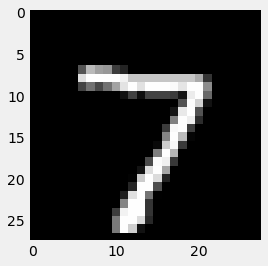

In [59]:
plt.imshow(x_test[0], cmap="gray")
plt.grid()

In [ ]:
example = encoder.predict([ x_test[0].reshape(-1, 28, 28, 1) ])
plt.imshow(example[0].reshape((8,8)), cmap="gray")
plt.grid()

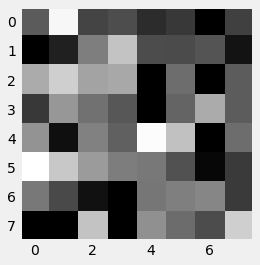

In [60]:
plt.imshow(example[0].reshape((8,8)), cmap="gray")
plt.grid()

In [61]:
ae_out = autoencoder.predict([ x_test[0].reshape(-1, 28, 28, 1) ])
img = ae_out[0]  # predict is done on a vector, and returns a vector, even if its just 1 element, so we still need to grab the 0th
#plt.imshow(ae_out[0], cmap="gray")

1/1 [==============================] - 0s 56ms/step


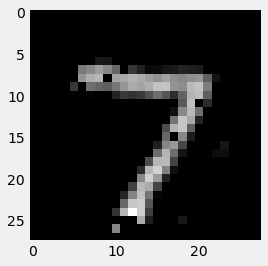

In [62]:
plt.imshow(img.reshape((28,28)),cmap="gray")
plt.grid()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               100480    
                                                                 
 dense_24 (Dense)            (None, 128)               16512     
                                                                 
 dense_25 (Dense)            (None, 784)               101136    
                                                                 
 reshape_5 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
Total params: 218,128
Trainable params: 218,128
Non-tra

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
1688/1688 [==============================] - 8s 4ms/step - loss: 0.0154 - accuracy: 0.8138 - val_loss: 0.0101 - val_accuracy: 0.8152
Epoch 2/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0093 - accuracy: 0.8151 - val_loss: 0.0089 - val_accuracy: 0.8153
Epoch 3/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0085 - accuracy: 0.8151 - val_loss: 0.0083 - val_accuracy: 0.8153
Epoch 4/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0081 - accuracy: 0.8151 - val_loss: 0.0080 - val_accuracy: 0.8153
Epoch 5/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0079 - accuracy: 0.8151 - val_loss: 0.0079 - val_accuracy: 0.8153
Epoch 6/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0077 - accuracy: 0.8151 - val_loss: 0.0077 - val_accuracy: 0.8153
Epoch 7/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0076 - accuracy: 0.8151 - val_loss: 0.0077 - val_accuracy:

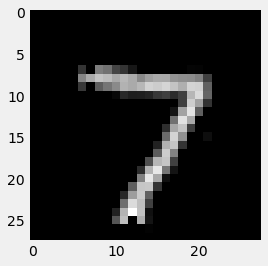

In [68]:
encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = keras.layers.Flatten()(encoder_input)
encoder_output = keras.layers.Dense(128, activation="relu")(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.Dense(128, activation="relu")(encoder_output)
x = keras.layers.Dense(784, activation="relu")(decoder_input)
decoder_output = keras.layers.Reshape((28, 28, 1))(x)

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

autoencoder.compile(opt, loss='mse',metrics=['accuracy'])

history = autoencoder.fit(
      x_train,
      x_train,
      epochs=10, 
      batch_size=32, validation_split=0.10
        ) 

example = encoder.predict([ x_test[0].reshape(-1, 28, 28, 1) ])

plt.imshow(x_test[0], cmap="gray")
plt.grid()

plt.imshow(example[0].reshape((16,8)), cmap="gray")
plt.grid()

ae_out = autoencoder.predict([ x_test[0].reshape(-1, 28, 28, 1) ])
img = ae_out[0]  # predict is done on a vector, and returns a vector, even if its just 1 element, so we still need to grab the 0th
plt.imshow(img.reshape((28,28)),cmap="gray")
plt.grid()

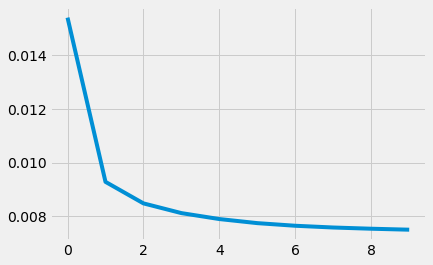

In [69]:
t_loss=history.history['loss']
plt.plot(t_loss)

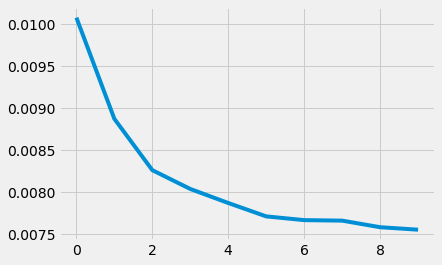

In [70]:
v_loss=history.history['val_loss']
plt.plot(v_loss)

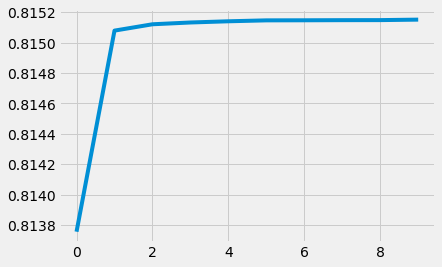

In [71]:
t_acc=history.history['accuracy']
plt.plot(t_acc)

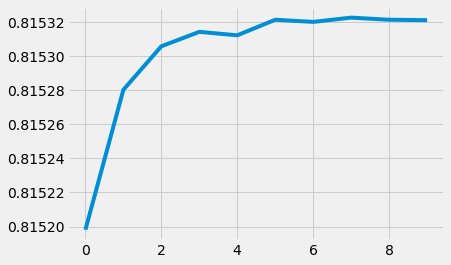

In [72]:
v_acc=history.history['val_accuracy']
plt.plot(v_acc)

313/313 [==============================] - 1s 2ms/step


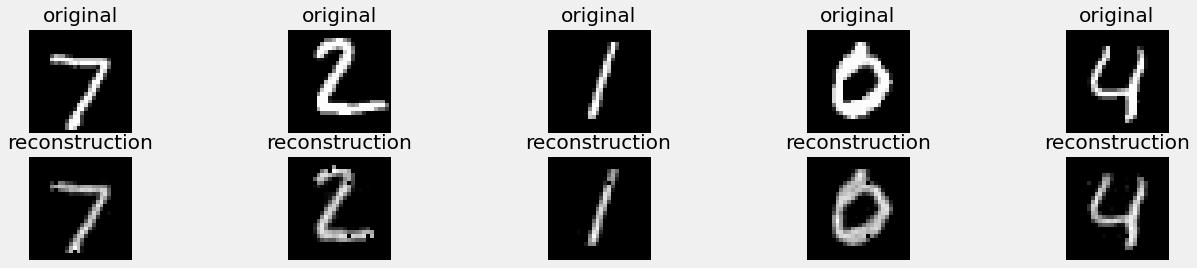

In [73]:
pred = autoencoder.predict(x_test)
plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('original')
    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('reconstruction')
plt.show()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_26 (Dense)            (None, 256)               200960    
                                                                 
 dense_27 (Dense)            (None, 256)               65792     
                                                                 
 dense_28 (Dense)            (None, 784)               201488    
                                                                 
 reshape_6 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
Total params: 468,240
Trainable params: 468,240
Non-tra

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
1688/1688 [==============================] - 13s 7ms/step - loss: 0.0124 - accuracy: 0.8143 - val_loss: 0.0082 - val_accuracy: 0.8153
Epoch 2/10
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0075 - accuracy: 0.8151 - val_loss: 0.0071 - val_accuracy: 0.8153
Epoch 3/10
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0068 - accuracy: 0.8151 - val_loss: 0.0068 - val_accuracy: 0.8153
Epoch 4/10
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0065 - accuracy: 0.8151 - val_loss: 0.0064 - val_accuracy: 0.8153
Epoch 5/10
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0064 - accuracy: 0.8151 - val_loss: 0.0063 - val_accuracy: 0.8153
Epoch 6/10
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0063 - accuracy: 0.8151 - val_loss: 0.0062 - val_accuracy: 0.8153
Epoch 7/10
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0062 - accuracy: 0.8151 - val_loss: 0.0061 - val_ac

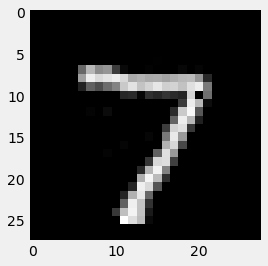

In [74]:
encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = keras.layers.Flatten()(encoder_input)
encoder_output = keras.layers.Dense(256, activation="relu")(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.Dense(256, activation="relu")(encoder_output)
x = keras.layers.Dense(784, activation="relu")(decoder_input)
decoder_output = keras.layers.Reshape((28, 28, 1))(x)

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

autoencoder.compile(opt, loss='mse',metrics=['accuracy'])

history = autoencoder.fit(
      x_train,
      x_train,
      epochs=10, 
      batch_size=32, validation_split=0.10
        ) 

example = encoder.predict([ x_test[0].reshape(-1, 28, 28, 1) ])

plt.imshow(x_test[0], cmap="gray")
plt.grid()

plt.imshow(example[0].reshape((16,16)), cmap="gray")
plt.grid()

ae_out = autoencoder.predict([ x_test[0].reshape(-1, 28, 28, 1) ])
img = ae_out[0]  # predict is done on a vector, and returns a vector, even if its just 1 element, so we still need to grab the 0th
plt.imshow(img.reshape((28,28)),cmap="gray")
plt.grid()

What outputs do you get if you pass a non-digit image (Try Fashion MNIST) and random noise images through the
network?

Text(0.5, 1.0, 'train loss')

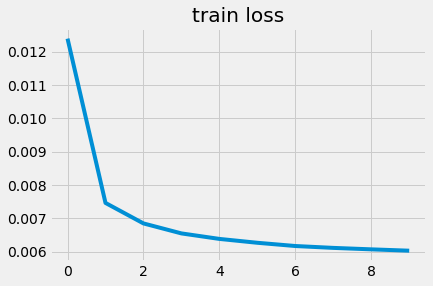

In [81]:
t_loss=history.history['loss']
plt.plot(t_loss)
plt.title('train loss')

Text(0.5, 1.0, 'val loss')

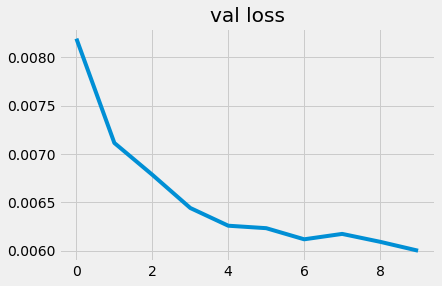

In [82]:
v_loss=history.history['val_loss']
plt.plot(v_loss)
plt.title('val loss')

Text(0.5, 1.0, 'train accuracy')

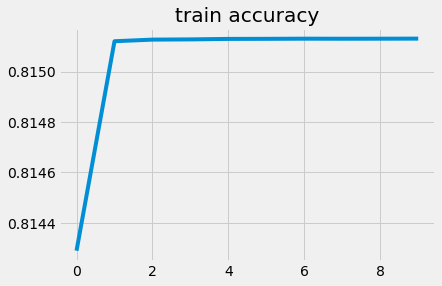

In [83]:
t_acc=history.history['accuracy']
plt.plot(t_acc)
plt.title('train accuracy')

Text(0.5, 1.0, 'val accuracy')

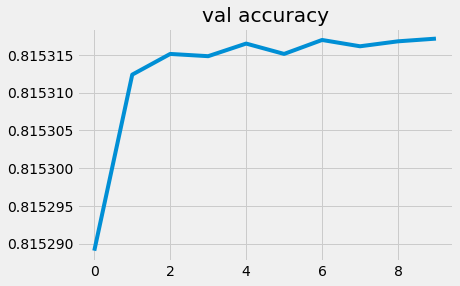

In [84]:
t_acc=history.history['val_accuracy']
plt.plot(t_acc)
plt.title('val accuracy')

313/313 [==============================] - 1s 2ms/step


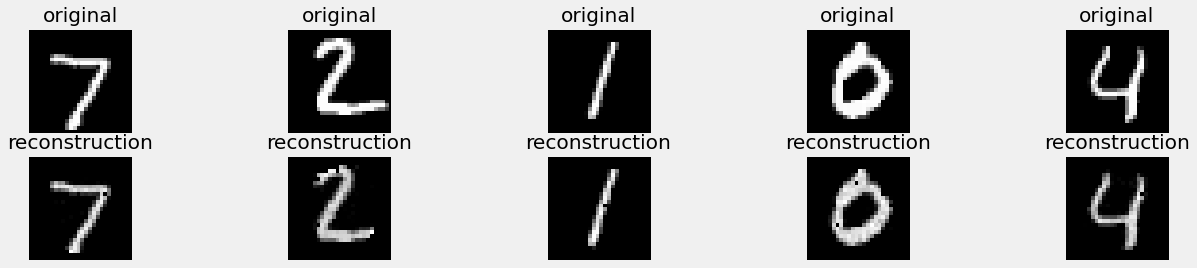

In [80]:
pred = autoencoder.predict(x_test)
plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('original')
    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('reconstruction')
plt.show()

In [85]:
from tensorflow.keras.datasets import fashion_mnist

(x_train2, y_train2), (x_test2, y_test2) = fashion_mnist.load_data()

x_train2 = x_train2.astype('float32') / 255.
x_test2 = x_test2.astype('float32') / 255.

print (x_train2.shape)
print (x_test2.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


1/1 [==============================] - 0s 16ms/step


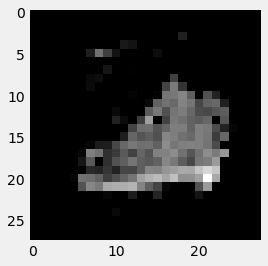

In [86]:
ae_out2 = autoencoder.predict([ x_test2[0].reshape(-1, 28, 28, 1) ])
img2 = ae_out2[0]  # predict is done on a vector, and returns a vector, even if its just 1 element, so we still need to grab the 0th
plt.imshow(img2.reshape((28,28)),cmap="gray")
plt.grid()

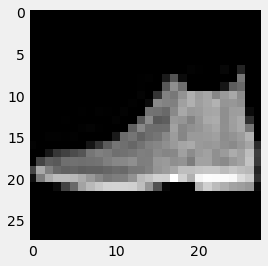

In [87]:
plt.imshow(x_test2[0], cmap="gray")
plt.grid()

313/313 [==============================] - 1s 2ms/step


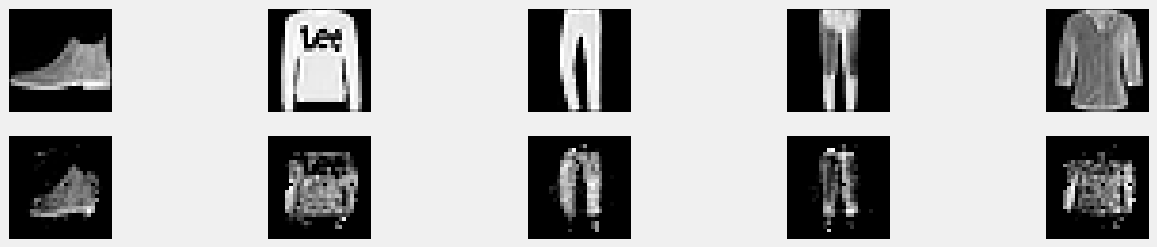

In [91]:
pred = autoencoder.predict(x_test2)
plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test2[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [88]:
noise_factor = 0.7
x_train_noisy = x_train2 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test2 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

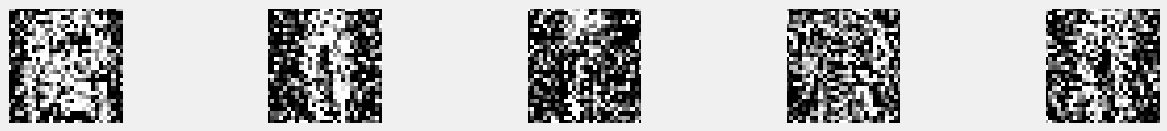

In [89]:
plt.figure(figsize=(20, 2))
for i in range(1, 5 + 1):
    ax = plt.subplot(1, 5, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

313/313 [==============================] - 1s 2ms/step


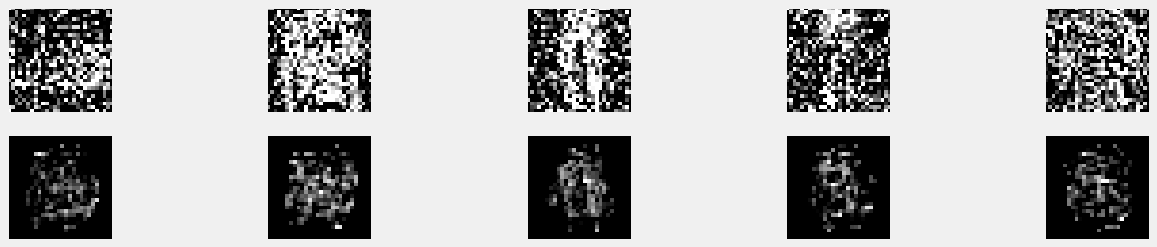

In [90]:
pred = autoencoder.predict(x_test_noisy)
plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

##3. Sparse Autoencoders##
Design an over-complete autoencoder with Sparsity regularization (Check L1 Penalty in torch). We impose sparsity by adding
L1 penalty on the hidden layer activation. L1 penalty is nothing but L1 norm on the output of hidden layer. Here, the
parameter controls the degree of sparsity (the one you pass to L1 Penalty function while defining the model). Higher the value,
more sparser the activations are. You can vary the value of this parameter and observe the change in filter visualizations.
Also, if the sparsity is too much, it could lead to bad reconstruction error.

1. Plot the training-validation plot for the different sparsity values chosen
2. Compare the average hidden layer activations of the Sparse AutoEncoder with that of the Standard AutoEncoder (in
the above question). Also compare visually the differences in the output for different sparsities. What differences do
you observe?
3. Now, try to visualize the learned filters of this Sparse AutoEncoder as images. What difference do you observe in the
structure of these filters from the ones you learned using the Standard AutoEncoder?

Model: "Sparse-Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 SAE-Input-Layer (InputLayer  [(None, 28)]             0         
 )                                                               
                                                                 
 SAE-Encoder-Hidden-Layer (D  (None, 16)               464       
 ense)                                                           
                                                                 
 SAE-Bottleneck-Layer (Dense  (None, 16)               272       
 )                                                               
                                                                 
 SAE-Decoder-Hidden-Layer (D  (None, 16)               272       
 ense)                                                           
                                                                 
 SAE-Output-Layer (Dense)    (None, 28)   

1864/1875 [============================>.] - ETA: 0s - loss: 0.0364 - accuracy: 0.2616

1875/1875 [==============================] - 8s 4ms/step - loss: 0.0362 - accuracy: 0.2618 - val_loss: 0.0115 - val_accuracy: 0.3001
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0084 - accuracy: 0.3172 - val_loss: 0.0062 - val_accuracy: 0.3177
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0054 - accuracy: 0.3249 - val_loss: 0.0045 - val_accuracy: 0.3178
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0041 - accuracy: 0.3240 - val_loss: 0.0037 - val_accuracy: 0.3167
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0035 - accuracy: 0.3244 - val_loss: 0.0032 - val_accuracy: 0.3190
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0031 - accuracy: 0.3258 - val_loss: 0.0029 - val_accuracy: 0.3201
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0028 - accuracy: 0.3279 - val_loss: 0.0026 - val_accuracy: 0.3208
Epo

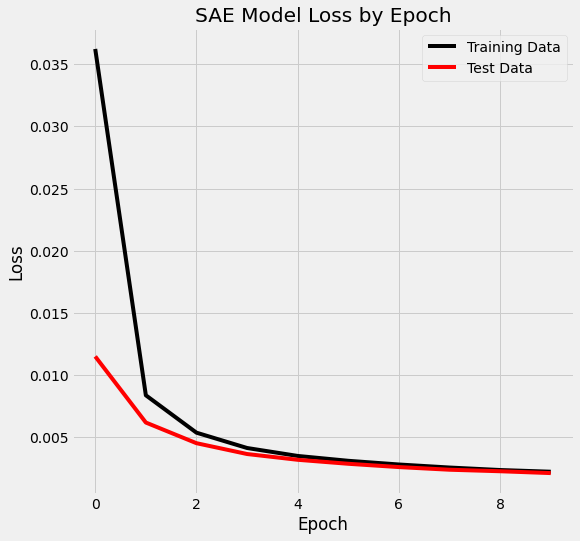

In [92]:
# Shapes
SAE_n_inputs=x_train.shape[1] #--- No. of neurons for the input and output layers
SAE_n_hidden=16 #--- No. of neurons for the hidden layers (including bottleneck)

# Layers
SAE_visible = Input(shape=(SAE_n_inputs,), name='SAE-Input-Layer') #--- Input-Layer 
SAE_enc_hidden = Dense(units=SAE_n_hidden, activation='relu', name='SAE-Encoder-Hidden-Layer')(SAE_visible) #--- Encoder-Hidden-Layer 
SAE_bottleneck = Dense(units=SAE_n_hidden, activation='relu', activity_regularizer=keras.regularizers.L1(0.0001), name='SAE-Bottleneck-Layer')(SAE_enc_hidden) #--- Bottleneck-Layer
SAE_dec_hidden = Dense(units=SAE_n_hidden, activation='relu', name='SAE-Decoder-Hidden-Layer')(SAE_bottleneck) #--- Decoder-Hidden-Layer 
SAE_output = Dense(units=SAE_n_inputs, activation='sigmoid', name='SAE-Output-Layer')(SAE_dec_hidden) #--- Output-Layer

# Define Sparse autoencoder model
SAE_model = Model(inputs=SAE_visible, outputs=SAE_output, name='Sparse-Autoencoder-Model')

# Compile Sparse autoencoder model
SAE_model.compile(optimizer='adam', loss='mse', metrics= ['accuracy'])

# Print model summary
print(SAE_model.summary())


# Fit the Sparse autoencoder model to reconstruct input
SAE_history = SAE_model.fit(x_train, x_train, epochs=10, batch_size=32, verbose=1, validation_data=(x_test, x_test))


#---------- Plot a loss chart ----------#
fig, ax = plt.subplots(figsize=(8,8))
plt.title(label='SAE Model Loss by Epoch', loc='center')
ax.plot(SAE_history.history['accuracy'], label='Training Data', color='black')
ax.plot(SAE_history.history['val_accuracy'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.legend()
plt.show()


#----------- Save SAE Encoder Model ----------#

# Define an encoder model without the decoder
SAE_encoder = Model(inputs=SAE_visible, outputs=SAE_bottleneck)

# Compile encoder model
SAE_encoder.compile(optimizer='adam', loss='mse',metrics= ['accuracy'])

# Save the encoder model to file
#SAE_encoder.save(main_dir+'/data/SAE_encoder.h5')

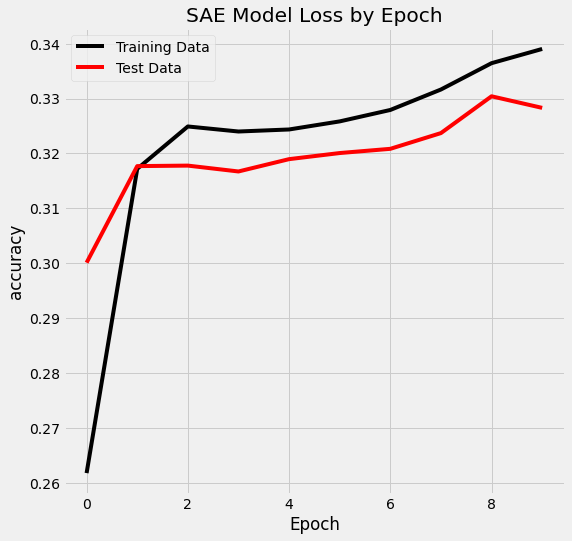

In [95]:
fig, ax = plt.subplots(figsize=(8,8))
plt.title(label='SAE Model Loss by Epoch', loc='center')
ax.plot(SAE_history.history['accuracy'], label='Training Data', color='black')
ax.plot(SAE_history.history['val_accuracy'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 17ms/step


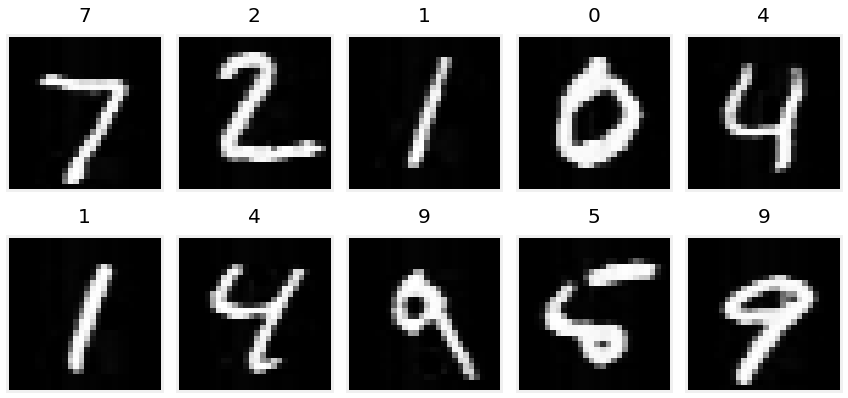

In [93]:
# Process images with Sparse-Autoencoder
for i in range(0, 10):
    img=SAE_model.predict(x_test[i])
    if i==0: 
        processed_imgs=np.copy(img) 
    else:
        processed_imgs=np.concatenate((processed_imgs, img))
processed_imgs=processed_imgs.reshape(10, 28, 28)

# Display processed images
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(processed_imgs[n])
        axs[i,j].set(title=y_test[n])
        axs[i,j].grid(False)
        # Hide axes ticks
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        n=n+1
plt.show() 

changing regularizer value


Model: "Sparse-Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 SAE-Input-Layer (InputLayer  [(None, 28)]             0         
 )                                                               
                                                                 
 SAE-Encoder-Hidden-Layer (D  (None, 16)               464       
 ense)                                                           
                                                                 
 SAE-Bottleneck-Layer (Dense  (None, 16)               272       
 )                                                               
                                                                 
 SAE-Decoder-Hidden-Layer (D  (None, 16)               272       
 ense)                                                           
                                                                 
 SAE-Output-Layer (Dense)    (None, 28)   

1872/1875 [============================>.] - ETA: 0s - loss: 0.0986 - accuracy: 0.0712

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0986 - accuracy: 0.0712 - val_loss: 0.0814 - val_accuracy: 0.0732
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0806 - accuracy: 0.0723 - val_loss: 0.0813 - val_accuracy: 0.0732
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0805 - accuracy: 0.0722 - val_loss: 0.0813 - val_accuracy: 0.0732
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0805 - accuracy: 0.0723 - val_loss: 0.0812 - val_accuracy: 0.0732
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0805 - accuracy: 0.0721 - val_loss: 0.0813 - val_accuracy: 0.0732
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0805 - accuracy: 0.0724 - val_loss: 0.0812 - val_accuracy: 0.0732
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0805 - accuracy: 0.0721 - val_loss: 0.0812 - val_accuracy: 0.0732
Epo

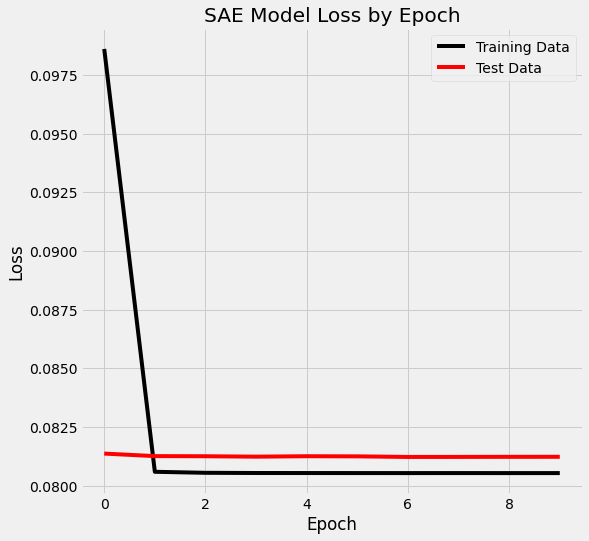

In [97]:
# Shapes
SAE_n_inputs=x_train.shape[1] #--- No. of neurons for the input and output layers
SAE_n_hidden=16 #--- No. of neurons for the hidden layers (including bottleneck)

# Layers
SAE_visible = Input(shape=(SAE_n_inputs,), name='SAE-Input-Layer') #--- Input-Layer 
SAE_enc_hidden = Dense(units=SAE_n_hidden, activation='relu', name='SAE-Encoder-Hidden-Layer')(SAE_visible) #--- Encoder-Hidden-Layer 
SAE_bottleneck = Dense(units=SAE_n_hidden, activation='relu', activity_regularizer=keras.regularizers.L1(0.01), name='SAE-Bottleneck-Layer')(SAE_enc_hidden) #--- Bottleneck-Layer
SAE_dec_hidden = Dense(units=SAE_n_hidden, activation='relu', name='SAE-Decoder-Hidden-Layer')(SAE_bottleneck) #--- Decoder-Hidden-Layer 
SAE_output = Dense(units=SAE_n_inputs, activation='sigmoid', name='SAE-Output-Layer')(SAE_dec_hidden) #--- Output-Layer

# Define Sparse autoencoder model
SAE_model = Model(inputs=SAE_visible, outputs=SAE_output, name='Sparse-Autoencoder-Model')

# Compile Sparse autoencoder model
SAE_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Print model summary
print(SAE_model.summary())


# Fit the Sparse autoencoder model to reconstruct input
SAE_history = SAE_model.fit(x_train, x_train, epochs=10, batch_size=32, verbose=1, validation_data=(x_test, x_test))


#---------- Plot a loss chart ----------#
fig, ax = plt.subplots(figsize=(8,8))
plt.title(label='SAE Model Loss by Epoch', loc='center')
ax.plot(SAE_history.history['loss'], label='Training Data', color='black')
ax.plot(SAE_history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.legend()
plt.show()


#----------- Save SAE Encoder Model ----------#

# Define an encoder model without the decoder
SAE_encoder = Model(inputs=SAE_visible, outputs=SAE_bottleneck)

# Compile encoder model
SAE_encoder.compile(optimizer='adam', loss='mse')

# Save the encoder model to file
#SAE_encoder.save(main_dir+'/data/SAE_encoder.h5')

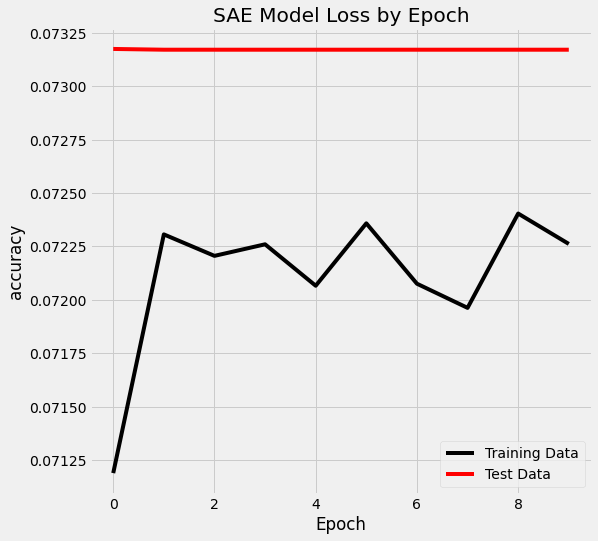

In [98]:
fig, ax = plt.subplots(figsize=(8,8))
plt.title(label='SAE Model Loss by Epoch', loc='center')
ax.plot(SAE_history.history['accuracy'], label='Training Data', color='black')
ax.plot(SAE_history.history['val_accuracy'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 17ms/step


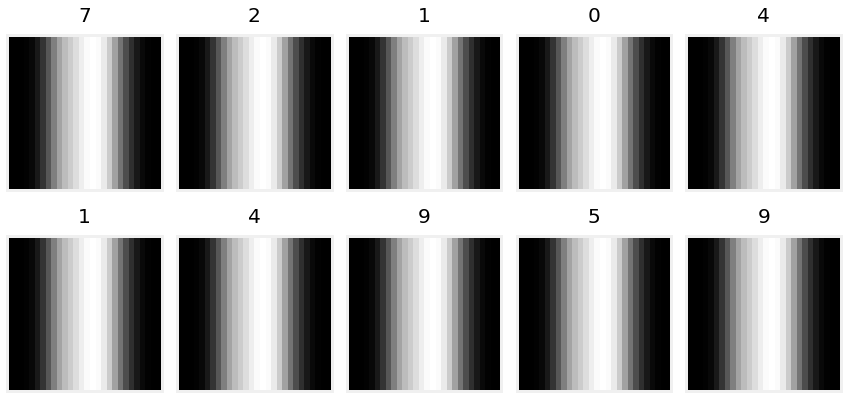

In [100]:
# Process images with Sparse-Autoencoder
for i in range(0, 10):
    img=SAE_model.predict(x_test[i])
    if i==0: 
        processed_imgs=np.copy(img) 
    else:
        processed_imgs=np.concatenate((processed_imgs, img))
processed_imgs=processed_imgs.reshape(10, 28, 28)

# Display processed images
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(processed_imgs[n])
        axs[i,j].set(title=y_test[n])
        axs[i,j].grid(False)
        # Hide axes ticks
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        n=n+1
plt.show() 

other value

Model: "Sparse-Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 SAE-Input-Layer (InputLayer  [(None, 28)]             0         
 )                                                               
                                                                 
 SAE-Encoder-Hidden-Layer (D  (None, 16)               464       
 ense)                                                           
                                                                 
 SAE-Bottleneck-Layer (Dense  (None, 16)               272       
 )                                                               
                                                                 
 SAE-Decoder-Hidden-Layer (D  (None, 16)               272       
 ense)                                                           
                                                                 
 SAE-Output-Layer (Dense)    (None, 28)   

1874/1875 [============================>.] - ETA: 0s - loss: 0.0214 - accuracy: 0.2708

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0214 - accuracy: 0.2708 - val_loss: 0.0036 - val_accuracy: 0.3116
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0028 - accuracy: 0.3266 - val_loss: 0.0022 - val_accuracy: 0.3216
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0020 - accuracy: 0.3317 - val_loss: 0.0018 - val_accuracy: 0.3276
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0017 - accuracy: 0.3384 - val_loss: 0.0016 - val_accuracy: 0.3368
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0015 - accuracy: 0.3478 - val_loss: 0.0013 - val_accuracy: 0.3426
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0013 - accuracy: 0.3540 - val_loss: 0.0012 - val_accuracy: 0.3516
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0012 - accuracy: 0.3547 - val_loss: 0.0011 - val_accuracy: 0.3490
Epo

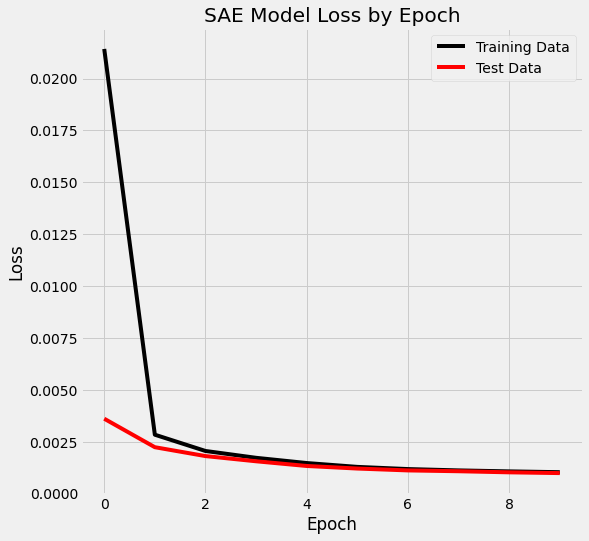

In [101]:
# Shapes
SAE_n_inputs=x_train.shape[1] #--- No. of neurons for the input and output layers
SAE_n_hidden=16 #--- No. of neurons for the hidden layers (including bottleneck)

# Layers
SAE_visible = Input(shape=(SAE_n_inputs,), name='SAE-Input-Layer') #--- Input-Layer 
SAE_enc_hidden = Dense(units=SAE_n_hidden, activation='relu', name='SAE-Encoder-Hidden-Layer')(SAE_visible) #--- Encoder-Hidden-Layer 
SAE_bottleneck = Dense(units=SAE_n_hidden, activation='relu', activity_regularizer=keras.regularizers.L1(0.000001), name='SAE-Bottleneck-Layer')(SAE_enc_hidden) #--- Bottleneck-Layer
SAE_dec_hidden = Dense(units=SAE_n_hidden, activation='relu', name='SAE-Decoder-Hidden-Layer')(SAE_bottleneck) #--- Decoder-Hidden-Layer 
SAE_output = Dense(units=SAE_n_inputs, activation='sigmoid', name='SAE-Output-Layer')(SAE_dec_hidden) #--- Output-Layer

# Define Sparse autoencoder model
SAE_model = Model(inputs=SAE_visible, outputs=SAE_output, name='Sparse-Autoencoder-Model')

# Compile Sparse autoencoder model
SAE_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Print model summary
print(SAE_model.summary())


# Fit the Sparse autoencoder model to reconstruct input
SAE_history = SAE_model.fit(x_train, x_train, epochs=10, batch_size=32, verbose=1, validation_data=(x_test, x_test))


#---------- Plot a loss chart ----------#
fig, ax = plt.subplots(figsize=(8,8))
plt.title(label='SAE Model Loss by Epoch', loc='center')
ax.plot(SAE_history.history['loss'], label='Training Data', color='black')
ax.plot(SAE_history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.legend()
plt.show()


#----------- Save SAE Encoder Model ----------#

# Define an encoder model without the decoder
SAE_encoder = Model(inputs=SAE_visible, outputs=SAE_bottleneck)

# Compile encoder model
SAE_encoder.compile(optimizer='adam', loss='mse')

# Save the encoder model to file
#SAE_encoder.save(main_dir+'/data/SAE_encoder.h5')

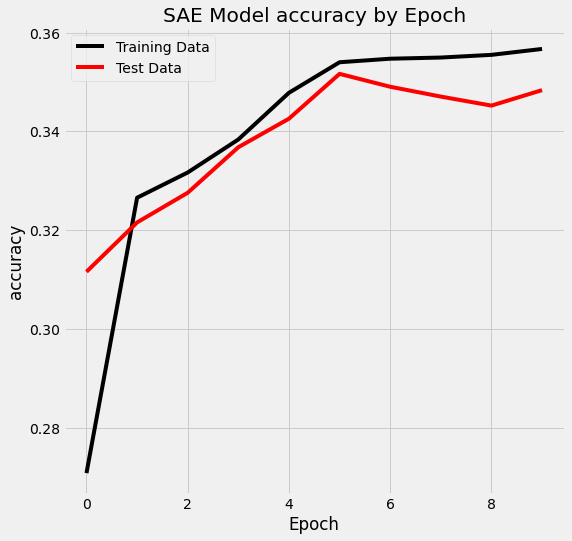

In [104]:
fig, ax = plt.subplots(figsize=(8,8))
plt.title(label='SAE Model accuracy by Epoch', loc='center')
ax.plot(SAE_history.history['accuracy'], label='Training Data', color='black')
ax.plot(SAE_history.history['val_accuracy'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 15ms/step


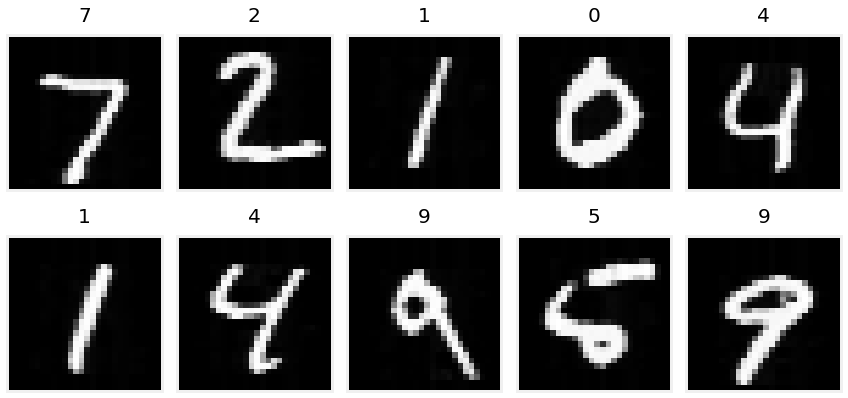

In [103]:
# Process images with Sparse-Autoencoder
for i in range(0, 10):
    img=SAE_model.predict(x_test[i])
    if i==0: 
        processed_imgs=np.copy(img) 
    else:
        processed_imgs=np.concatenate((processed_imgs, img))
processed_imgs=processed_imgs.reshape(10, 28, 28)

# Display processed images
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(processed_imgs[n])
        axs[i,j].set(title=y_test[n])
        axs[i,j].grid(False)
        # Hide axes ticks
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        n=n+1
plt.show() 

1/1 [==============================] - 0s 18ms/step


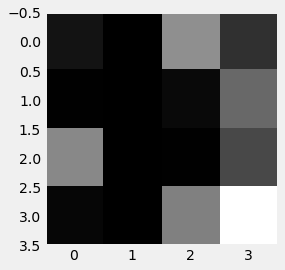

In [108]:
example = SAE_encoder.predict([ x_test[0]])
plt.imshow(example[0].reshape((4,4)), cmap="gray")
plt.grid()

##4 Denoising Autoencoders##

Design a denoising autoencoder with just one hidden unit (Take hidden size as 256).
1. What happens when you pass images corrupted with noise to the previously trained Standard Autoencoders (From Q2)
? Compare it with Denoising autoencoders

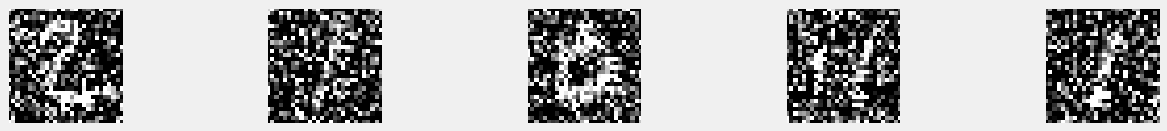

In [109]:
noise_factor = 0.7
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
#Here is how the noisy images look right now.
plt.figure(figsize=(20, 2))
for i in range(1, 5 + 1):
    ax = plt.subplot(1, 5, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [45]:
x_train_noisy.shape

(60000, 28, 28)

In [110]:
encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = keras.layers.Flatten()(encoder_input)
encoder_output = keras.layers.Dense(256, activation="relu")(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.Dense(256, activation="relu")(encoder_output)
x = keras.layers.Dense(784, activation="relu")(decoder_input)
decoder_output = keras.layers.Reshape((28, 28, 1))(x)

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

autoencoder.compile(opt, loss='mse', metrics=['accuracy'])

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_29 (Dense)            (None, 256)               200960    
                                                                 
 dense_30 (Dense)            (None, 256)               65792     
                                                                 
 dense_31 (Dense)            (None, 784)               201488    
                                                                 
 reshape_7 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
Total params: 468,240
Trainable params: 468,240
Non-tra

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [111]:
history_n = autoencoder.fit(
      x_train_noisy,
      x_train,
      epochs=10, 
      batch_size=32, validation_split=0.10
        ) 

Epoch 1/10
1688/1688 [==============================] - 11s 6ms/step - loss: 0.0346 - accuracy: 0.8058 - val_loss: 0.0279 - val_accuracy: 0.8079
Epoch 2/10
1688/1688 [==============================] - 11s 7ms/step - loss: 0.0268 - accuracy: 0.8089 - val_loss: 0.0262 - val_accuracy: 0.8097
Epoch 3/10
1688/1688 [==============================] - 12s 7ms/step - loss: 0.0251 - accuracy: 0.8094 - val_loss: 0.0252 - val_accuracy: 0.8098
Epoch 4/10
1688/1688 [==============================] - 11s 6ms/step - loss: 0.0243 - accuracy: 0.8096 - val_loss: 0.0247 - val_accuracy: 0.8092
Epoch 5/10
1688/1688 [==============================] - 11s 6ms/step - loss: 0.0238 - accuracy: 0.8098 - val_loss: 0.0243 - val_accuracy: 0.8095
Epoch 6/10
1688/1688 [==============================] - 11s 6ms/step - loss: 0.0235 - accuracy: 0.8099 - val_loss: 0.0241 - val_accuracy: 0.8094
Epoch 7/10
1688/1688 [==============================] - 11s 6ms/step - loss: 0.0231 - accuracy: 0.8100 - val_loss: 0.0239 - val_ac

313/313 [==============================] - 1s 2ms/step


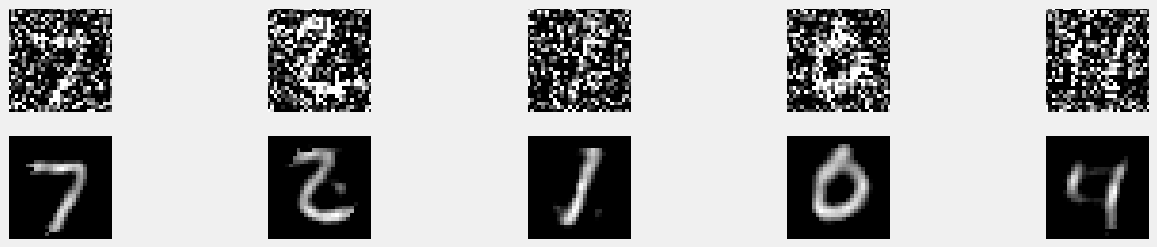

In [112]:
pred = autoencoder.predict(x_test_noisy)
plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

2. Change the noise level (typical values: **0.3, 0.5, 0.8, 0.9**) and repeat the above experiments.
 What kind of variations
do you observe in the results? (Both Visually and by MSE)

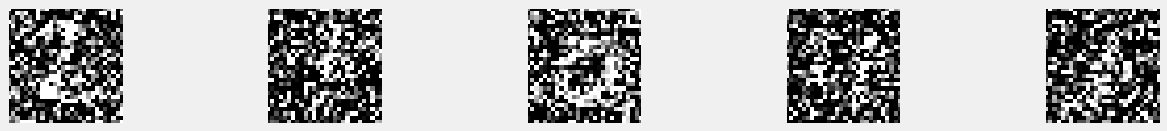

In [122]:
noise_factor = 0.9
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
#Here is how the noisy images look right now.
plt.figure(figsize=(20, 2))
for i in range(1, 5 + 1):
    ax = plt.subplot(1, 5, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [123]:
history_n = autoencoder.fit(
      x_train_noisy,
      x_train,
      epochs=10, 
      batch_size=32, validation_split=0.10
        )

Epoch 1/10
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0293 - accuracy: 0.8063 - val_loss: 0.0287 - val_accuracy: 0.8070
Epoch 2/10
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0281 - accuracy: 0.8070 - val_loss: 0.0287 - val_accuracy: 0.8065
Epoch 3/10
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0278 - accuracy: 0.8072 - val_loss: 0.0288 - val_accuracy: 0.8070
Epoch 4/10
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0276 - accuracy: 0.8073 - val_loss: 0.0289 - val_accuracy: 0.8057
Epoch 5/10
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0274 - accuracy: 0.8074 - val_loss: 0.0288 - val_accuracy: 0.8062
Epoch 6/10
1688/1688 [==============================] - 11s 6ms/step - loss: 0.0272 - accuracy: 0.8075 - val_loss: 0.0287 - val_accuracy: 0.8068
Epoch 7/10
1688/1688 [==============================] - 11s 6ms/step - loss: 0.0271 - accuracy: 0.8075 - val_loss: 0.0288 - val_ac

313/313 [==============================] - 1s 2ms/step


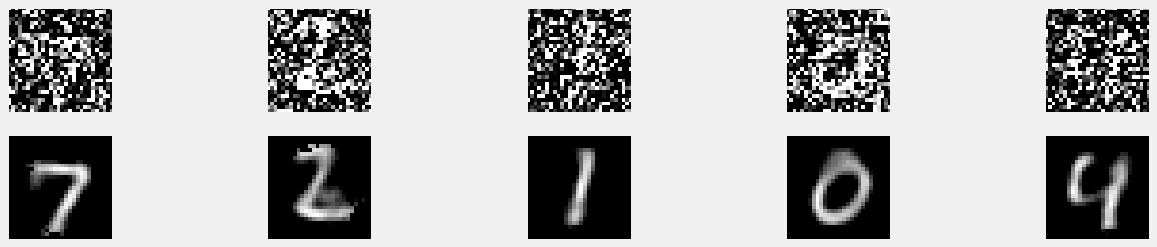

In [124]:
pred = autoencoder.predict(x_test_noisy)
plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

0.5

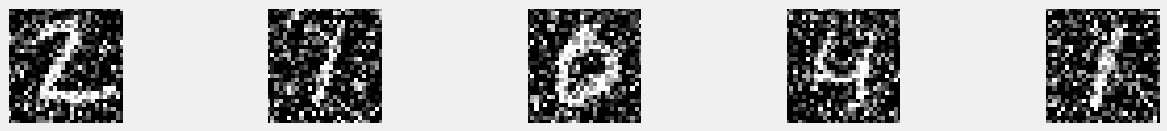

In [52]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
#Here is how the noisy images look right now.
plt.figure(figsize=(20, 2))
for i in range(1, 5 + 1):
    ax = plt.subplot(1, 5, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [53]:
history_n = autoencoder.fit(
      x_train_noisy,
      x_train,
      epochs=3, 
      batch_size=32, validation_split=0.10
        )

Epoch 1/3
1688/1688 [==============================] - 15s 9ms/step - loss: 0.0181 - val_loss: 0.0177
Epoch 2/3
1688/1688 [==============================] - 14s 8ms/step - loss: 0.0175 - val_loss: 0.0176
Epoch 3/3
1688/1688 [==============================] - 14s 8ms/step - loss: 0.0173 - val_loss: 0.0175


313/313 [==============================] - 1s 4ms/step


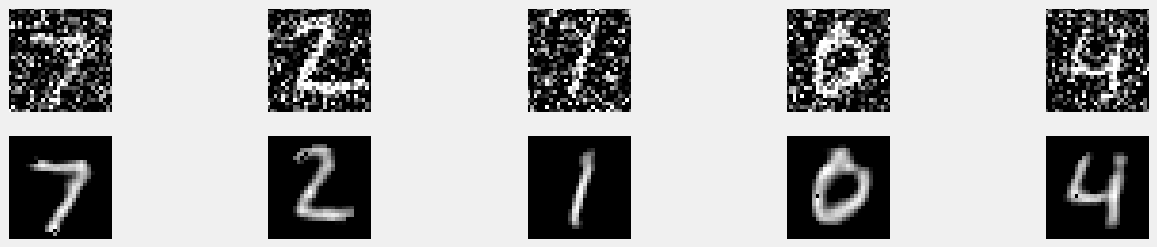

In [54]:
pred = autoencoder.predict(x_test_noisy)
plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

0.8

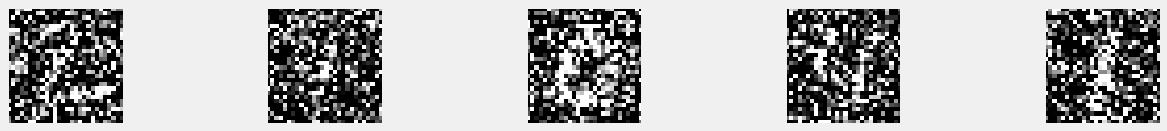

In [55]:
noise_factor = 0.8
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
#Here is how the noisy images look right now.
plt.figure(figsize=(20, 2))
for i in range(1, 5 + 1):
    ax = plt.subplot(1, 5, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [56]:
history_n = autoencoder.fit(
      x_train_noisy,
      x_train,
      epochs=3, 
      batch_size=32, validation_split=0.10
        )

Epoch 1/3
1688/1688 [==============================] - 14s 8ms/step - loss: 0.0276 - val_loss: 0.0266
Epoch 2/3
1688/1688 [==============================] - 14s 8ms/step - loss: 0.0265 - val_loss: 0.0268
Epoch 3/3
1688/1688 [==============================] - 17s 10ms/step - loss: 0.0261 - val_loss: 0.0269


313/313 [==============================] - 1s 4ms/step


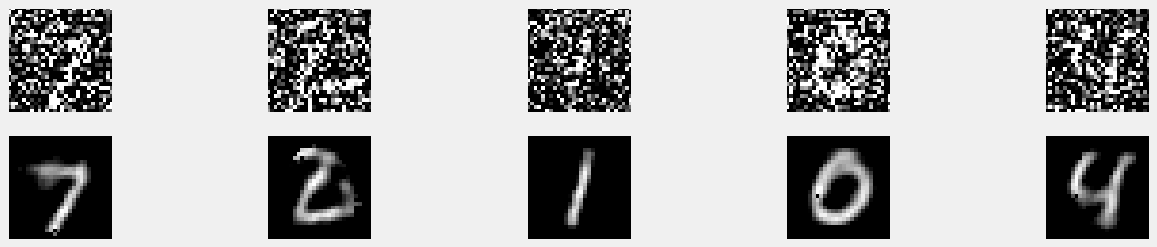

In [57]:
pred = autoencoder.predict(x_test_noisy)
plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

0.9

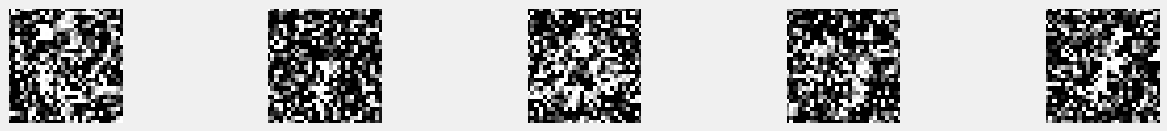

In [58]:
noise_factor = 0.9
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
#Here is how the noisy images look right now.
plt.figure(figsize=(20, 2))
for i in range(1, 5 + 1):
    ax = plt.subplot(1, 5, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [79]:
history_n = autoencoder.fit(
      x_train_noisy,
      x_train,
      epochs=3, 
      batch_size=32, validation_split=0.10
        )

Epoch 1/3
1688/1688 [==============================] - 16s 10ms/step - loss: 0.0286 - val_loss: 0.0298
Epoch 2/3
1688/1688 [==============================] - 15s 9ms/step - loss: 0.0285 - val_loss: 0.0300
Epoch 3/3
1688/1688 [==============================] - 15s 9ms/step - loss: 0.0284 - val_loss: 0.0301


313/313 [==============================] - 1s 4ms/step


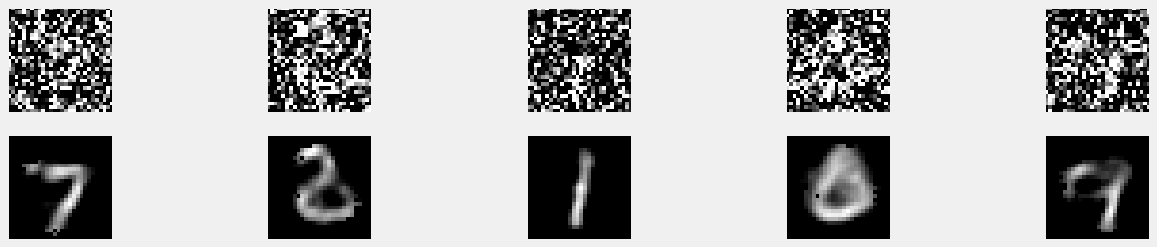

In [80]:
pred = autoencoder.predict(x_test_noisy)
plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

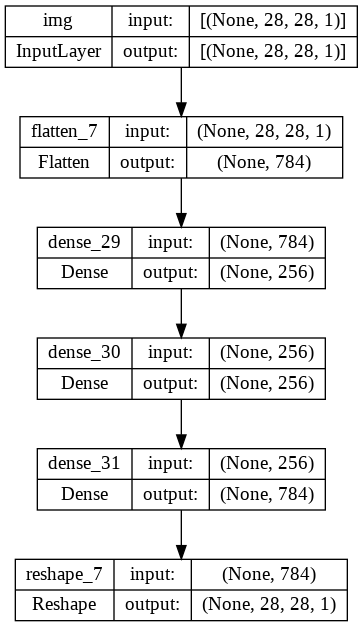

In [125]:
from tensorflow.keras.utils import plot_model
plot_model(autoencoder,show_shapes=True)

##5 Convolutional Autoencoders##
AE can also be implemented as fully convolutional networks with the decoder consisting of upsampling operations of any of
these variants - i) Unpooling or ii) Unpooling + Deconvolution or iii) Deconvolution.

1. Train a Convolutional AE for the MNIST data with **3 convolutional layers** for encoder and the decoder being the
mirror of encoder (i.e a total of 7 convolutional layers for AE with the final convolutional layer mapping to the output).

Architecture for the encoder part:

• Input-Conv1(8 3x3 filters with stride 1)

• 2x2 Maxpooling

• Conv2(16 3x3 filters with stride 1)

• 2x2 Maxpooling

• Conv3(16 3x3 filters with stride 1)



• 2x2 Maxpooling

At the output of the final 2x2 Maxpooling we have the encoded representation. 

This needs to followed by the
decoder network. Experiment with all the three types of upsampling. 
Refer to this report for good description on
deconvolution and unpooling in deep learning.

Keeping all the other parameters the same, report on reconstruction error and convergence with the different types of
upsampling. Also visualize the decoder weights for the three cases. What do you observe?

up sampling 

In [126]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()  # loads the popular "mnist" training dataset

x_train = x_train/255.0  # scales the data. pixel values range from 0 to 255, so this makes it range 0 to 1
x_test = x_test/255.0  # scales the data. pixel values range from 0 to 255, so this makes it range 0 to 1

In [127]:
input_img = tf.keras.layers.Input(shape=(28, 28, 1)) # adapt this if using `channels_first` image data format

x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

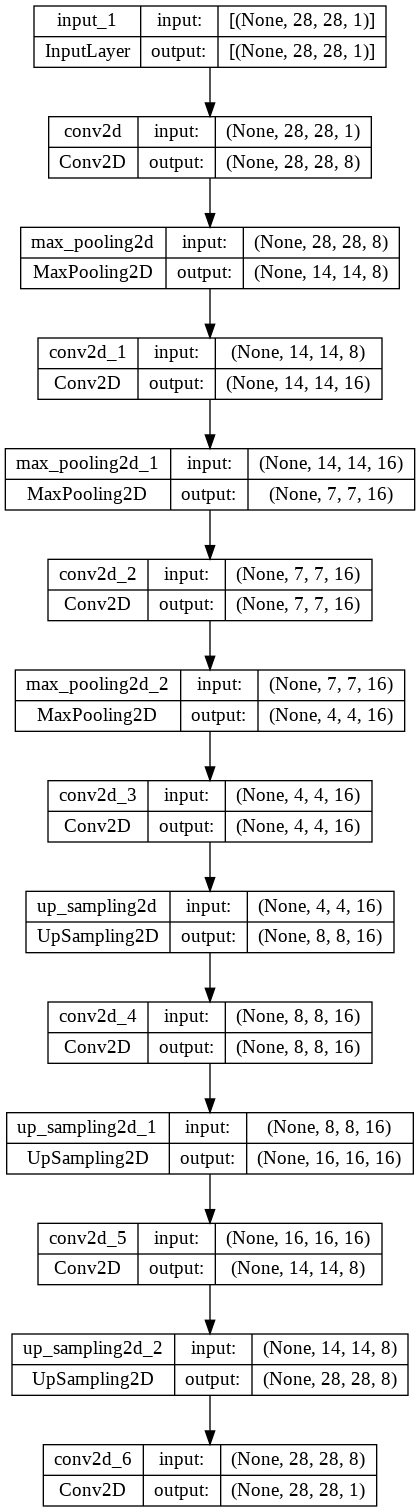

In [128]:
from tensorflow.keras.utils import plot_model
plot_model(autoencoder,show_shapes=True)

In [4]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [5]:
x_train.data.shape

(60000, 28, 28, 1)

In [6]:
y_train.data.shape

(60000,)

In [7]:
x_test.data.shape

(10000, 28, 28, 1)

In [129]:
history_n = autoencoder.fit(
      x_train,
      x_train,
      epochs=10, 
      batch_size=128, validation_split=0.10
        )

Epoch 1/10
422/422 [==============================] - 57s 131ms/step - loss: 0.1902 - accuracy: 0.7999 - val_loss: 0.1278 - val_accuracy: 0.8051
Epoch 2/10
422/422 [==============================] - 55s 130ms/step - loss: 0.1175 - accuracy: 0.8081 - val_loss: 0.1119 - val_accuracy: 0.8108
Epoch 3/10
422/422 [==============================] - 56s 133ms/step - loss: 0.1072 - accuracy: 0.8106 - val_loss: 0.1046 - val_accuracy: 0.8116
Epoch 4/10
422/422 [==============================] - 54s 129ms/step - loss: 0.1019 - accuracy: 0.8117 - val_loss: 0.1007 - val_accuracy: 0.8120
Epoch 5/10
422/422 [==============================] - 54s 127ms/step - loss: 0.0984 - accuracy: 0.8123 - val_loss: 0.0973 - val_accuracy: 0.8129
Epoch 6/10
422/422 [==============================] - 55s 130ms/step - loss: 0.0957 - accuracy: 0.8128 - val_loss: 0.0953 - val_accuracy: 0.8130
Epoch 7/10
422/422 [==============================] - 54s 128ms/step - loss: 0.0935 - accuracy: 0.8131 - val_loss: 0.0933 - val_ac

313/313 [==============================] - 4s 13ms/step


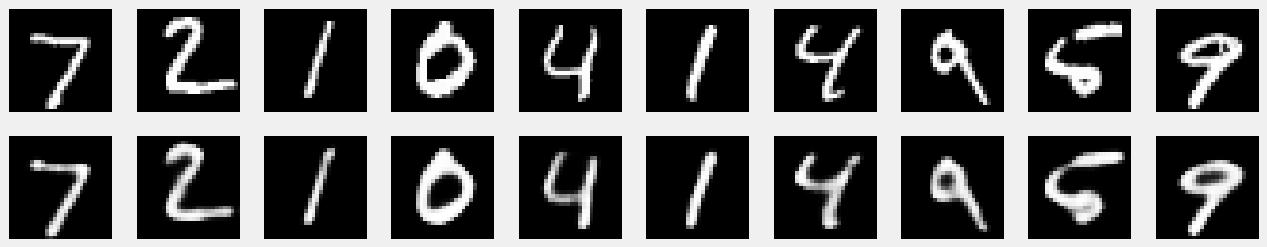

In [130]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()